# Roteiro Levenberg-Marquadt

Esse código é um protótipo de função para a implementação do algoritmo de Levenberg-Marquadt, o qual é utilizado para estimar parâmetros não-lineares. 

\begin{equation}
\Gamma (\textbf{m}) = \Psi (\textbf{m}) + \mu \sum\limits^{6}_{j=1}\alpha_{j}\varphi_{j}(\textbf{m})
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.gravmag import prism
from fatiando.mesher import Prism
from fatiando.vis import mpl, myv
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
import mag_polyprism_functions as mfun
import polyprism_tests as tests
% matplotlib inline

/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


# Entrada

### Parâmetros para o modelo direto

In [2]:
M = 3 # number of vertices per prism
L = 3 # number of prisms
P = L*(M+2) # number of parameters

inc, dec = -60., 50. # inclination and declination of regional field
incs, decs = 70., -50.      # wrong direction or remanent

#r = 1000. # radial distance for each vertice
r = np.zeros(M)
r[::2] = 3000.
r[1::2] = np.sqrt(2.)*3000.

# Cartesian coordinates of the origin of each prism
x0 = np.zeros(L) 
y0 = np.zeros(L)

dz = 100.0    # thickness of each prism

In [3]:
props={'magnetization': utils.ang2vec(3, inc, dec)} # physical property

z0 = 0.    # depth of the top the shallowest prism

l = []   # list of prisms

### creating the lis of prisms

for i in range(L):
    l.append([r, x0[i], y0[i], z0 + dz*i, z0 + dz*(i + 1), props])

### Pontos de observação

In [4]:
#area over which the data are calculated
#x minimum, x maximum, y minimum and y maximum
area = [-10000, 10000, -10000, 10000] 

#number of data along the y and x directions
shape = (80,80)

#total number of data
N = shape[0]*shape[1]

#coordinates x and y of the data
x = np.linspace(area[0],area[1],shape[0]) # points in x
y = np.linspace(area[2],area[3],shape[0]) # points in y
xp,yp = np.meshgrid(x,y)    # creating mesh points
xp = xp.ravel()
yp = yp.ravel()

#vertical coordinates of the data
zp = -350. - 500.*utils.gaussian2d(xp, yp, 17000, 21000, 21000, 18500, angle=21) # relief

### Parâmetros exigidos durante a inversão

In [5]:
lamb = 0.001 # Marquadt's parameter
dlamb = 10.  # step for Marquadt's parameter

# limits for parameters in meters
rmin = 100.
rmax = 8000.
x0min = -5000.
x0max = 5000.
y0min = -5000.
y0max = 5000.

delta = 10. # increment of derivatives

m_out = np.zeros(M + 2)  # outcropping body parameters

# Gerando os dados preditos

In [6]:
m = mfun.param_vec(l, M, L) # true parameters vector

In [7]:
model = mfun.pol2cart(l, M, L) # list of classes of prisms

In [8]:
d = polyprism.tf(xp, yp, zp, model, inc, dec) # predict data

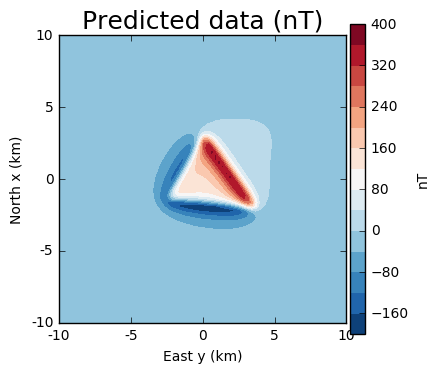

In [9]:
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("Predicted data (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, d,shape, 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
mpl.m2km()
mpl.show()

# Algoritmo Levenberg-Marquadt

1- Iteração $k=0$: chute inicial $\mathbf{m}_0$ em que todos os elementos satisfaçam os vínculos de desigualdade e um valor real positivo grande para $\lambda$

In [10]:
#props={'magnetization': utils.ang2vec(3, inc, dec)} # physical property

#z0 = 0.    # depth of the top the shallowest prism

rini = np.zeros(M).fill(5000)

lini = []   # list of parameters of each prisms

### creating the list of prisms
for i in range(L):
    lini.append([r, x0[i], y0[i], z0 + dz*i, z0 + dz*(i + 1), props])

In [11]:
m0 = mfun.param_vec(lini, M, L) # inicial parameters vector

In [12]:
model0 = mfun.pol2cart(lini, M, L) # list of classes of prisms

2) Calcula os parâmetros transformados $\breve{\mathbf{m}}_k$

Os parâmetros transformados são calculados a partir da equação:

\begin{equation}
\breve{m}_i = f(m_i) = - \ln\left(\frac{m_{i\, max} - m_{i\, min}}{m_i - m_{i\, min}}\right)
\end{equation}

In [13]:
mt = mfun.trans_parameter(m0, M, L, rmin, rmax, x0min, x0max, y0min, y0max) # transformated parameters vector

A transformação inversa dos parâmetros é dada pela equação:

\begin{equation}
m_i = f^{-1}(\breve{m}_i) = m_{i\, min} + \left(\frac{m_{i\, max} - m_{i\, min}}{1 + e^{-\breve{m}_i}}\right)
\end{equation}

In [14]:
m_volta = mfun.trans_inv_parameter(mt, M, L, rmin, rmax, x0min, x0max, y0min, y0max) # inverse transformation

In [15]:
np.allclose(m_volta, m0) # validation test

True

In [16]:
# creating a model from the transformated parameters vector

ltrans = [] # list of parameters of each prisms

ii = i*(M+2)

### creating the list of prisms
for i in range(L):
    ltrans.append([mt[ii:ii+M], mt[ii+M], mt[ii+(M+1)], z0 + dz*i, z0 + dz*(i + 1), props])

In [17]:
modeltrans = mfun.pol2cart(ltrans, M, L)

3) laço externo: calcula $\nabla^2\Gamma (\hat{\mathbf{m}}_k)$, $\nabla\Gamma (\hat{\mathbf{m}}_k)$ e $T(\hat{\mathbf{m}}_k)$:

In [18]:
grad = mfun.gradient_data(xp, yp, zp, ltrans, M, L, d, delta, delta, delta, inc, dec)
H = mfun.Hessian_data(xp, yp, zp, ltrans, M, L, delta, delta, delta, inc, dec)

In [19]:
grad = mfun.gradient_phi_1(M, L, grad, lamb)
grad = mfun.gradient_phi_2(M, L, grad, lamb)
grad = mfun.gradient_phi_3(M, L, grad, m_out, lamb)
grad = mfun.gradient_phi_4(M, L, grad, m_out[-2:], lamb)
grad = mfun.gradient_phi_5(M, L, grad, lamb)
grad = mfun.gradient_phi_6(M, L, grad, lamb)

In [20]:
H = mfun.Hessian_phi_1(M, L, H, lamb)
H = mfun.Hessian_phi_2(M, L, H, lamb)
H = mfun.Hessian_phi_3(M, L, H, lamb)
H = mfun.Hessian_phi_4(M, L, H, lamb)
H = mfun.Hessian_phi_5(M, L, H, lamb)
H = mfun.Hessian_phi_6(M, L, H, lamb)

a) laço interno: calcula $\Delta \breve{\mathbf{m}}_k$ solucionando o sistema linear abaixo

\begin{equation}
\left[\nabla^2\Gamma (\hat{\mathbf{m}}_k) + \lambda \mathbf{I} \right]\mathbf{T}(\hat{\mathbf{m}}_k) \Delta\breve{\mathbf{m}}_k \approx - \nabla \Gamma (\hat{\mathbf{m}}_k)
\end{equation}

In [21]:
T = np.zeros(P)

In [22]:
for i in range(0, L*(M+2), M+2):
    T[i:M+i] = (rmax - mt[i:M+i])*(mt[i:M+i] - rmin)/(rmax - rmin)
    T[M+i] = (rmax - mt[M+i])*(mt[M+i] - rmin)/(rmax - rmin)
    T[M+i+1] = (rmax - mt[M+i+1])*(mt[M+i+1] - rmin)/(rmax - rmin)

In [25]:
i,j = np.diag_indices_from(H)

In [28]:
H[i,j] += lamb

H[i,:] *= T

    
b) calcula $\breve{\mathbf{m}}_{k+1} = \breve{\mathbf{m}}_k + \Delta\breve{\mathbf{m}}_k$
    
c) computa $\hat{\mathbf{m}}_{k+1}$ 
    
d) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ 
    
i) $\lambda = \lambda\cdot d\lambda$

ii) retorne para 3)a)

e) $\lambda = \lambda/d\lambda$

4) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ e $\frac{|\Gamma (\hat{\mathbf{m}}_{k+1})- \Gamma (\hat{\mathbf{m}}_k)|}{|\Gamma (\hat{\mathbf{m}}_k)|}>\varepsilon$

a) $k=k+1$

b) Retorne para etapa 2)